In [2]:
import pandas as pd
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
df = pd.read_csv('malicious_phish.csv')
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [4]:
print(df['type'].unique())

['phishing' 'benign' 'defacement' 'malware']


Transformar qualquer uma que seja diferente de begign em malware

In [5]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['type'])
print(df['label'].unique())
df

[3 0 1 2]


,url,type,label
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3


In [6]:

vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3))
X = vectorizer.fit_transform(df['url']) # matriz de features
y = df['label'] # vector de etiquetas

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
clf = XGBClassifier(n_estimators=100, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
y_pred = clf.predict(X_test)

print("Relatorio de Classificação: ")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Acurácia: ", accuracy_score(y_test, y_pred))

Relatorio de Classificação: 
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85778
  defacement       0.97      0.99      0.98     19104
     malware       0.99      0.94      0.97      6521
    phishing       0.94      0.84      0.89     18836

    accuracy                           0.97    130239
   macro avg       0.97      0.94      0.95    130239
weighted avg       0.97      0.97      0.97    130239

Acurácia:  0.9670528797057717


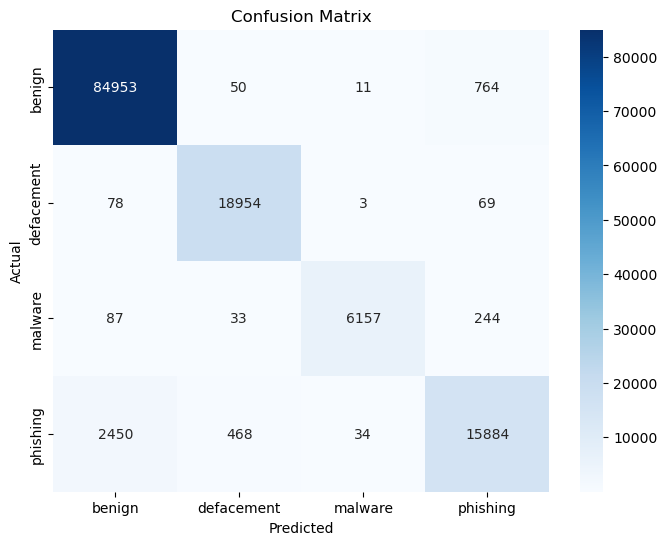

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

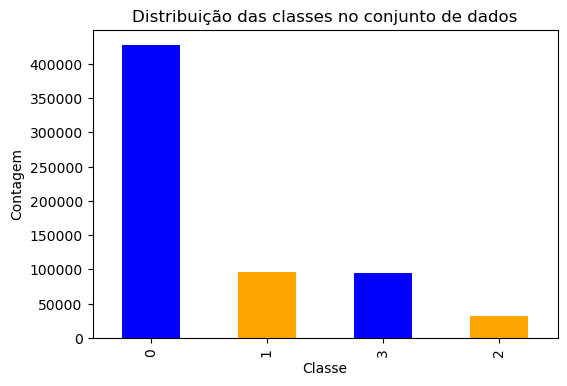

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Distribuição das classes no conjunto de dados")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

Removendo os prefixos como https e www

In [12]:
def remove_prefix(url):
    for prefix in ['https://', 'http://', 'www.']:
        if url.startswith(prefix):
            url = url[len(prefix):]
    return url

df['url'] = df['url'].apply(remove_prefix)

In [13]:
df

,url,type,label
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,garage-pirenne.be/index.php?option=com_content...,defacement,1
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3
651188,gamespot.com/xbox360/action/deadspace/,phishing,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3


In [14]:
def get_length(url):
    return len(url)

df['url_len'] = df['url'].apply(get_length)
df

,url,type,label,url_len
0,br-icloud.com.br,phishing,3,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228
...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44
651188,gamespot.com/xbox360/action/deadspace/,phishing,3,38
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45


In [15]:
def extract_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except:
        pri_domain = None
    return pri_domain

df['domain'] = df['url'].apply(extract_domain)

In [16]:
df

,url,type,label,url_len,domain
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net
...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,xbox360.ign.com
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,games.teamxbox.com
651188,gamespot.com/xbox360/action/deadspace/,phishing,3,38,gamespot.com
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,en.wikipedia.org


In [17]:
df.dropna(subset=['domain'], inplace=True)
df

,url,type,label,url_len,domain
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net
...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,xbox360.ign.com
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,games.teamxbox.com
651188,gamespot.com/xbox360/action/deadspace/,phishing,3,38,gamespot.com
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,en.wikipedia.org


In [18]:
def extract_root_domain(url):
    extracted = tld_extract(url)
    root_domain = extracted.domain
    return root_domain

df['root_domain'] = df['url'].apply(extract_root_domain)
df

,url,type,label,url_len,domain,root_domain
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,bopsecrets
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be,garage-pirenne
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net,adventure-nicaragua
...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,xbox360.ign.com,ign
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,games.teamxbox.com,teamxbox
651188,gamespot.com/xbox360/action/deadspace/,phishing,3,38,gamespot.com,gamespot
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,en.wikipedia.org,wikipedia


In [19]:
df.isnull().sum()

url            0
type           0
label          0
url_len        0
domain         0
root_domain    0
dtype: int64

In [20]:
df.duplicated().sum()

11912

In [21]:
df.drop_duplicates(inplace=True)
df

,url,type,label,url_len,domain,root_domain
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,bopsecrets
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be,garage-pirenne
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net,adventure-nicaragua
...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,xbox360.ign.com,ign
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,games.teamxbox.com,teamxbox
651188,gamespot.com/xbox360/action/deadspace/,phishing,3,38,gamespot.com,gamespot
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,en.wikipedia.org,wikipedia


Contagem de caracteres especiais

In [22]:
special_chars = ['/', '?', '=', '-', '.', '@']

def count_special_chars(url):
    return sum(url.count(char) for char in special_chars)

df['special_char_count'] = df['url'].apply(count_special_chars)
df.head()

,url,type,label,url_len,domain,root_domain,special_char_count
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,br-icloud,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,mp3raid,4
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,bopsecrets,5
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be,garage-pirenne,9
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net,adventure-nicaragua,8


Quantidade de subdomínios

In [23]:
def count_subdomains(url):
    # Divide the URL by '.' to count the segments.
    parts = url.split('.')
    # Consider that a valid domain has at least a domain and TLD.
    return max(0, len(parts) - 2)

df['subdomain_count'] = df['url'].apply(count_subdomains)
df[['url', 'subdomain_count']].head()

,url,subdomain_count
0,br-icloud.com.br,1
1,mp3raid.com/music/krizz_kaliko.html,1
2,bopsecrets.org/rexroth/cr/1.htm,1
3,garage-pirenne.be/index.php?option=com_content...,1
4,adventure-nicaragua.net/index.php?option=com_m...,1


Proporção de dígitos vs. letras

URLs muito recheadas de números podem ser suspeitas

In [24]:
def digit_letter_ratio(url):
    digit_count = sum(c.isdigit() for c in url)
    letter_count = sum(c.isalpha() for c in url)
    return digit_count / letter_count if letter_count > 0 else digit_count

df['digit_letter_ratio'] = df['url'].apply(digit_letter_ratio)
df.head()

,url,type,label,url_len,domain,root_domain,special_char_count,subdomain_count,digit_letter_ratio
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,br-icloud,3,1,0.000000
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,mp3raid,4,1,0.034483
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,bopsecrets,5,1,0.040000
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be,garage-pirenne,9,1,0.125000
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net,adventure-nicaragua,8,1,0.112821


TLD (Top-Level Domain)

Certos TLDs são mais propensos a serem usados para spam/phishing

In [25]:
def extract_tld(url):
    extracted = tld_extract(url)
    return extracted.suffix

df['tld'] = df['url'].apply(extract_tld)
print(df['tld'].value_counts())

tld
com           392775
org            50733
net            28025
de             13443
edu            10077
               ...  
czest.pl           1
donetsk.ua         1
edu.bb             1
edu.om             1
net.hk             1
Name: count, Length: 883, dtype: int64


In [26]:
data = df.drop(columns=['url', 'type', 'domain'])
data

,label,url_len,root_domain,special_char_count,subdomain_count,digit_letter_ratio,tld
0,3,16,br-icloud,3,1,0.000000,com.br
1,0,35,mp3raid,4,1,0.034483,com
2,0,31,bopsecrets,5,1,0.040000,org
3,1,77,garage-pirenne,9,1,0.125000,be
4,1,228,adventure-nicaragua,8,1,0.112821,net
...,...,...,...,...,...,...,...
651186,3,39,ign,6,2,0.571429,com
651187,3,44,teamxbox,8,1,0.241379,com
651188,3,38,gamespot,5,0,0.100000,com
651189,3,45,wikipedia,4,1,0.000000,org


In [27]:
data['root_domain'].value_counts()


root_domain
wikipedia                  13426
youtube                     8638
blogspot                    8459
facebook                    8362
yahoo                       5843
                           ...  
mitchell                       1
themarlowepapers               1
michaelowry                    1
memorial-chemindesdames        1
decentrix                      1
Name: count, Length: 147230, dtype: int64

In [28]:
data

,label,url_len,root_domain,special_char_count,subdomain_count,digit_letter_ratio,tld
0,3,16,br-icloud,3,1,0.000000,com.br
1,0,35,mp3raid,4,1,0.034483,com
2,0,31,bopsecrets,5,1,0.040000,org
3,1,77,garage-pirenne,9,1,0.125000,be
4,1,228,adventure-nicaragua,8,1,0.112821,net
...,...,...,...,...,...,...,...
651186,3,39,ign,6,2,0.571429,com
651187,3,44,teamxbox,8,1,0.241379,com
651188,3,38,gamespot,5,0,0.100000,com
651189,3,45,wikipedia,4,1,0.000000,org


In [29]:
import hashlib

def hash_encode(text):
    # Converte em string para evitar problemas se houver valores numéricos misturados
    text = str(text)
    hash_object = hashlib.md5(text.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [30]:
target_mapping = data.groupby('root_domain')['label'].mean().to_dict()
data['root_domain'] = data['root_domain'].map(target_mapping)
len(data['root_domain'].unique())

559

In [31]:
len(df['tld'].unique())

883

In [32]:
#data['tld'] = data['tld'].apply(hash_encode)
#len(data['tld'].unique())

In [33]:
# Calculando o target encoding para a coluna tld
target_mapping_tld = data.groupby('tld')['label'].mean().to_dict()
data['tld'] = data['tld'].map(target_mapping_tld)
len(data['tld'].unique())

278

In [34]:
x = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Aplicar otimização bayesiana

In [35]:


# Supondo que x e y já estejam definidos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Espaços de busca para cada classificador
param_spaces = {
    'RandomForestClassifier': {
        'n_estimators': (50, 500),
        'max_depth': (3, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    },
    'XGBClassifier': {
        'n_estimators': (50, 500),
        'max_depth': (3, 20),
        'learning_rate': (0.01, 0.3, 'log-uniform')
    },
    'AdaBoostClassifier': {
        'n_estimators': (50, 200),
        'learning_rate': (0.01, 1.0, 'log-uniform')
    },
    'KNeighborsClassifier': {
        'n_neighbors': (1, 30),
        'weights': ['uniform', 'distance'],
        'p': (1, 2)  # 1 para Manhattan, 2 para Euclidiana
    },
    'DecisionTreeClassifier': {
        'max_depth': (3, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    },
    'ExtraTreesClassifier': {
        'n_estimators': (50, 500),
        'max_depth': (3, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    },
    'GaussianNB': {
        'var_smoothing': (1e-9, 1e-5, 'log-uniform')
    }
}

# Lista de classificadores
classificadores = [
    RandomForestClassifier(random_state=42),
    XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
    AdaBoostClassifier(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    #GaussianNB()
]

In [36]:
results = []

modelos = {}

for clf in classificadores:
    if clf.__class__.__name__ not in param_spaces:
        print(f"Espaço de busca não definido para {clf.__class__.__name__}. Pulando...")
        continue

    print(f"Treinando {clf.__class__.__name__}...")

    bayes_search = BayesSearchCV(
        estimator = clf,
        search_spaces = param_spaces[clf.__class__.__name__],
        n_iter=32,
        cv=cv,
        scoring='accuracy',
        random_state=42,
        n_jobs=2
    )

    bayes_search.fit(x, y)

    print(f"Melhores parâmetros para {clf.__class__.__name__}:", bayes_search.best_params_)
    print(f"Melhor acurácia de validação para {clf.__class__.__name__}:", bayes_search.best_score_)
    print("-" * 50)

    best_clf = bayes_search.best_estimator_

    pipeline = Pipeline([
        ('classifier', best_clf)
    ])
    scores = cross_val_score(pipeline, data.drop(columns=['label']), data['label'], cv=5, scoring='accuracy')
    y_pred = cross_val_predict(pipeline, x, y, cv=5)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y, y_pred, average='weighted')
    modelos[clf.__class__.__name__] = best_clf
    results.append((clf.__class__.__name__, accuracy, recall, precision, f1))


Treinando RandomForestClassifier...
Melhores parâmetros para RandomForestClassifier: OrderedDict({'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500})
Melhor acurácia de validação para RandomForestClassifier: 0.9747122288172297
--------------------------------------------------
Treinando XGBClassifier...


/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:39:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:39:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:40:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:40:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:40:48] WARNING: /w

Melhores parâmetros para XGBClassifier: OrderedDict({'learning_rate': 0.023280016501525152, 'max_depth': 11, 'n_estimators': 380})
Melhor acurácia de validação para XGBClassifier: 0.9751045354174558
--------------------------------------------------
Treinando AdaBoostClassifier...


/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

Melhores parâmetros para AdaBoostClassifier: OrderedDict({'learning_rate': 0.3875621944495683, 'n_estimators': 50})
Melhor acurácia de validação para AdaBoostClassifier: 0.9566087574889099
--------------------------------------------------


/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

Treinando KNeighborsClassifier...
Melhores parâmetros para KNeighborsClassifier: OrderedDict({'n_neighbors': 8, 'p': 1, 'weights': 'distance'})
Melhor acurácia de validação para KNeighborsClassifier: 0.961648129614996
--------------------------------------------------
Treinando DecisionTreeClassifier...
Melhores parâmetros para DecisionTreeClassifier: OrderedDict({'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 9})
Melhor acurácia de validação para DecisionTreeClassifier: 0.9736294021897359
--------------------------------------------------
Treinando ExtraTreesClassifier...
Melhores parâmetros para ExtraTreesClassifier: OrderedDict({'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50})
Melhor acurácia de validação para ExtraTreesClassifier: 0.9731509811323127
--------------------------------------------------


In [37]:
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])
results = results.sort_values(by='Accuracy', ascending=False)
results

,Classifier,Accuracy,Recall,Precision,F1 Score
0,RandomForestClassifier,0.959951,0.959951,0.959983,0.959959
1,XGBClassifier,0.959278,0.959278,0.959246,0.959253
5,ExtraTreesClassifier,0.958934,0.958934,0.958671,0.958777
4,DecisionTreeClassifier,0.958631,0.958631,0.958366,0.958483
2,AdaBoostClassifier,0.948267,0.948267,0.945379,0.944275
3,KNeighborsClassifier,0.944423,0.944423,0.944964,0.944477


In [38]:
import joblib
import os

# Criar diretório para os modelos se não existir
os.makedirs('modelos', exist_ok=True)


# Opcional: Para salvar todos os modelos em um único arquivo
joblib.dump(modelos, 'modelos/todos_os_modelos.joblib')
print("Todos os modelos salvos com sucesso!")

Todos os modelos salvos com sucesso!


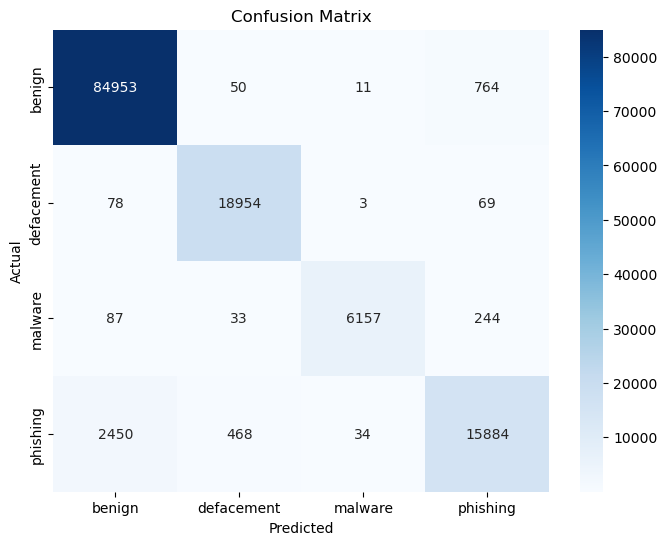

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

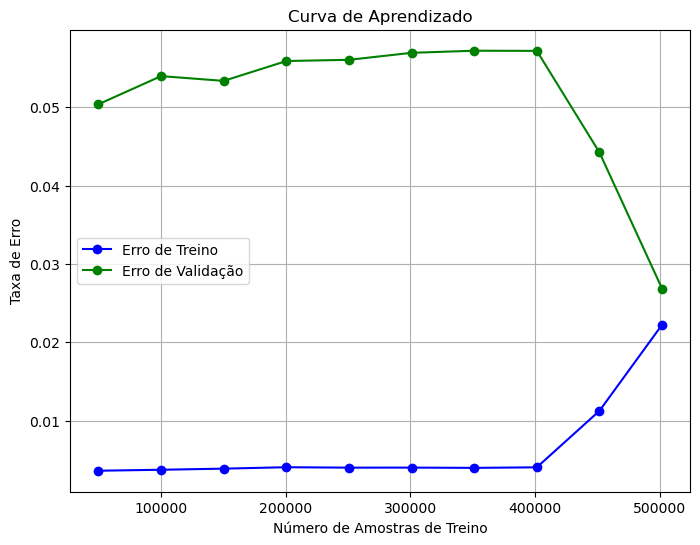

In [40]:
from sklearn.model_selection import learning_curve
import numpy as np

import matplotlib.pyplot as plt

# Obter os tamanhos de treino e as pontuações para treino e validação
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, x, y, cv=cv, scoring='accuracy', n_jobs=2, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calcular os erros (taxa de erro = 1 - acurácia)
train_errors = 1 - np.mean(train_scores, axis=1)
valid_errors = 1 - np.mean(valid_scores, axis=1)

# Plotar as curvas de aprendizado
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, 'o-', color='blue', label='Erro de Treino')
plt.plot(train_sizes, valid_errors, 'o-', color='green', label='Erro de Validação')
plt.xlabel('Número de Amostras de Treino')
plt.ylabel('Taxa de Erro')
plt.title('Curva de Aprendizado')
plt.legend(loc='best')
plt.grid(True)
plt.show()